<a href="https://colab.research.google.com/github/padfoot194/Pytorch_Learning/blob/main/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Convert MNIST image files into a tensor of 4-Dimension
#(no. of images, height, width, color channel)

transform= transforms.ToTensor()

In [3]:
#Download and Train data
train_data= datasets.MNIST(root='/CNN_data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.39MB/s]


In [4]:
#Download and Test data
test_data= datasets.MNIST(root='/CNN_data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /CNN_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /CNN_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
#Create a small batchsize for images...let's say 10
train_loader= DataLoader(train_data, batch_size=10, shuffle=True)
test_loader= DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# Define our CNN Model
# Describe convolutional layer and what it's doing.(2 convolutional layer)

#Conv2d(input_layer,output_layer,kernel_size,stride or step to move)
conv1=nn.Conv2d(1,6,3,1)
conv2=nn.Conv2d(6,16,3,1)

In [9]:
# Grab one MNIST record/an image

for i, (X_train,y_train) in enumerate(train_data):
  break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
# So, we've pulled out one image of 28X28 size. So we've grabbed one image

In [12]:
#Convert to 4D image

x= X_train.view(1,1,28,28)

In [13]:
#Let's perform our first convolution

x=F.relu(conv1(x))

In [14]:
x.shape

torch.Size([1, 6, 26, 26])

In [15]:
# 1 single image, 6 is the filters we've asked for in conv1.
#then comes the image size.it should be 28X28. but it is 26X26
#We didn't do any padding.So,at the edge of the image,some datapoints are
#lost.In real world problem,we should do padding to not lose any datapoint.

In [16]:
#Pass through the pooling layer.
x= F.max_pool2d(x,2,2)  #kernel of 2 and stride of 2.

In [17]:
x.shape

torch.Size([1, 6, 13, 13])

In [18]:
## 1 single image, 6 is the filters we've asked for in conv1.
#then comes the pooling. informations are shrunk in pooling.
#Thus a pooling layer is done.

In [19]:
#Do our second convolutional layer.

x=F.relu(conv2(x))

In [20]:
x.shape

torch.Size([1, 16, 11, 11])

In [21]:
#13X13 reduces to 11X11. Because no padding. Lose 2 pixels around the image.

In [22]:
#Another pooling layer.
x=F.max_pool2d(x,2,2)

In [23]:
x.shape

torch.Size([1, 16, 5, 5])

In [24]:
# Model class

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1= nn.Conv2d(1,6,3,1)
    self.conv2= nn.Conv2d(6,16,3,1)

    #Fully connected layer
    self.fc1= nn.Linear(5*5*16,120) #Flattening out to 120 neuron.
    self.fc2= nn.Linear(120,84)     #ager output 120 ekhane input.
    self.fc3= nn.Linear(84,10)      #ager output 84 ekhane input.

  def forward(self,X):
    X=F.relu(self.conv1(X))
    X=F.max_pool2d(X,2,2)         # 2X2 kernel and stride 2

    #Second pass
    X=F.relu(self.conv2(X))
    X=F.max_pool2d(X,2,2)         # 2X2 kernel and stride 2

    #Re-view to flatten it out.
    X= X.view(-1, 16*5*5)   #Negative 1 so that we can vary the batch size.

    #Fully connected Layer
    X= F.relu(self.fc1(X))
    X= F.relu(self.fc2(X))
    X= self.fc3(X)

    return F.log_softmax(X, dim=1)

In [25]:
# Create an instance of our model

torch.manual_seed(41)
model= ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
# Loss function optimizer

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.001)
#Smaller the lr, the longer it's gonna take to train.

In [32]:
import time
start_time= time.time()

#Create variables to Track things:
epochs= 5
train_losses= []
test_losses= []
train_correct= []
test_correct= []

#For loop of epochs
for i in range(epochs):
  trn_correct=0
  tst_correct=0

  #Train
  for b,(X_train,y_train) in enumerate(train_loader):
    b+=1    #start our batches at 1
    y_pred= model(X_train)  #Get predicted values from training set.Not flattened 2D
    loss= criterion(y_pred, y_train)  #Compare prediction to correct answer.

    #b+=1    #start our batches at 1
    #y_pred= model(X_train)  #Get predicted values from training set.Not flattened 2D
    #loss= criterion(y_pred, y_train)  #Compare prediction to correct answer.

    predicted= torch.max(y_pred.data,1)[1]  #add up the number of correct prediction.Indexed off first point.
    batch_correct= (predicted==y_train).sum()   #How many correct from this batch.
    trn_correct+= batch_correct   #keep track as long as in training.

    #Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print out some result
    if b%600==0:
      print(f'Epoch:{i} Batch:{b} Loss:{loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_correct)

  #Test
  with torch.no_grad():  #No gradient so we don't update our weights and bias.
    for b,(X_test,y_test) in enumerate(test_loader):
      y_val= model(X_test)
      predicted= torch.max(y_val.data,1)[1] #Adding up correct predictions
      tst_correct+= (predicted==y_test)   #T=1, F=0 and sum away.

  loss= criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_correct)


current_time= time.time()
total= current_time-start_time
print(f'Training took:{total/60} minutes')

Epoch:0 Batch:600 Loss:0.0035083782859146595
Epoch:0 Batch:1200 Loss:0.0020227667409926653
Epoch:0 Batch:1800 Loss:0.00014359336637426168
Epoch:0 Batch:2400 Loss:0.006023935042321682
Epoch:0 Batch:3000 Loss:0.00019805254123639315
Epoch:0 Batch:3600 Loss:0.0003215094329789281
Epoch:0 Batch:4200 Loss:0.00013303720334079117
Epoch:0 Batch:4800 Loss:0.00013116961054038256
Epoch:0 Batch:5400 Loss:0.007491172291338444
Epoch:0 Batch:6000 Loss:0.00026404534582979977
Epoch:1 Batch:600 Loss:0.0003380640409886837
Epoch:1 Batch:1200 Loss:0.14714379608631134
Epoch:1 Batch:1800 Loss:4.033394361613318e-05
Epoch:1 Batch:2400 Loss:2.9381999411270954e-05
Epoch:1 Batch:3000 Loss:6.436575495172292e-05
Epoch:1 Batch:3600 Loss:0.00028954408480785787
Epoch:1 Batch:4200 Loss:0.0031209480948746204
Epoch:1 Batch:4800 Loss:0.0001400594337610528
Epoch:1 Batch:5400 Loss:0.44415774941444397
Epoch:1 Batch:6000 Loss:0.9346203804016113
Epoch:2 Batch:600 Loss:0.00047568907029926777
Epoch:2 Batch:1200 Loss:0.000172095460

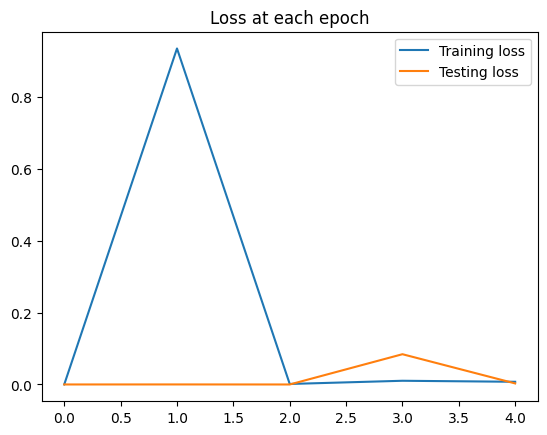

In [33]:
#Graph the loss at each epoch

train_losses=[tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.title('Loss at each epoch')
plt.legend()

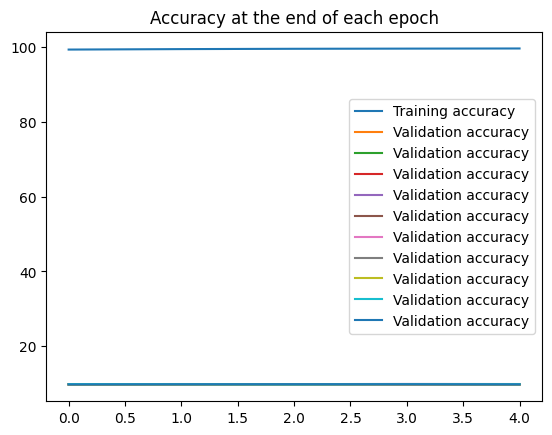

In [34]:
#Graph accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training accuracy")
plt.plot([t/100 for t in test_correct], label="Validation accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [35]:
test_load_everything= DataLoader(test_data,batch_size=10000, shuffle= False)

In [36]:
with torch.no_grad():
  correct=0
  for X_test, y_test in test_load_everything:
    y_val= model(X_test)
    predicted= torch.max(y_val.data,1)[1]
    correct+= (predicted==y_test).sum()

In [37]:
#Did for correct
correct.item()/len(test_data)*100

98.64

In [57]:
#Grab an image

test_data[2024] #tensor with an image in it. At the end, it shows the label.

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [58]:
#Grab just the data
test_data[2024][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [59]:
#Reshape it
test_data[2024][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

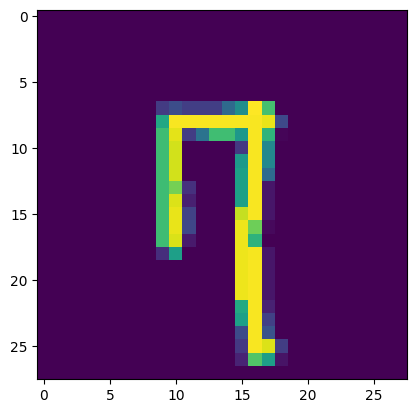

In [60]:
#show the image
plt.imshow(test_data[2024][0].reshape(28,28))

In [61]:
#Pass the image through model

model.eval()
with torch.no_grad():
  new_prediction= model(test_data[2024][0].view(1,1,28,28))
  #batch size of 1,1 color channel, 28X18 image

In [62]:
#check new prediction.
new_prediction

tensor([[-1.6832e+01, -8.7673e+00, -1.2964e+01, -1.4986e+01, -1.2339e+01,
         -1.5464e+01, -2.4038e+01, -5.8624e-03, -1.7226e+01, -5.1704e+00]])

In [63]:
new_prediction.argmax()

tensor(7)